# Prodigy InfoTech Internship: Task 4

Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

Sample Dataset: [Twitter Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

hue_palette = ['#800080', '#8B0000', '#222222', '#006400']
sns.set_theme(context='notebook', style='whitegrid', palette=hue_palette)

from tqdm.auto import tqdm
tqdm.pandas()

# Understand the Shape of the Data

In [2]:
df = pd.read_csv('data/Twitter Sentiment Analysis.csv', names=['id', 'entity', 'sentiment', 'text'])

In [3]:
df.head()

,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
df.duplicated().sum()

2700

In [6]:
df.isna().sum()

id             0
entity         0
sentiment      0
text         686
dtype: int64

# Data Cleaning

In [7]:
df = df.drop_duplicates().dropna().drop(columns='id')
df['sentiment'] = df['sentiment'].astype('category')

In [8]:
import re
import string

In [9]:
def clean_text(text):
    # Remove links
    text = re.sub(r'https?\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers and words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)

    return text.lower().strip()

In [10]:
df['text'] = df['text'].progress_apply(clean_text)

  0%|          | 0/71656 [00:00<?, ?it/s]

In [11]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ahmedkandil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmedkandil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    filtered_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

In [13]:
df['text'] = df['text'].progress_apply(preprocess_text)

  0%|          | 0/71656 [00:00<?, ?it/s]

# Data Exploration

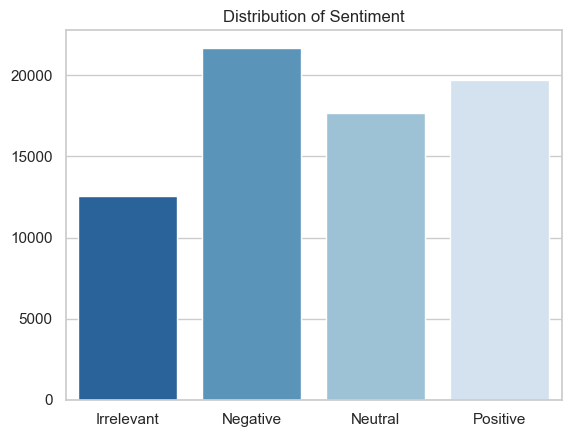

In [14]:
sns.countplot(data=df, x='sentiment', palette='Blues_r')

plt.title('Distribution of Sentiment')
plt.xlabel('')
plt.ylabel('')

plt.show();

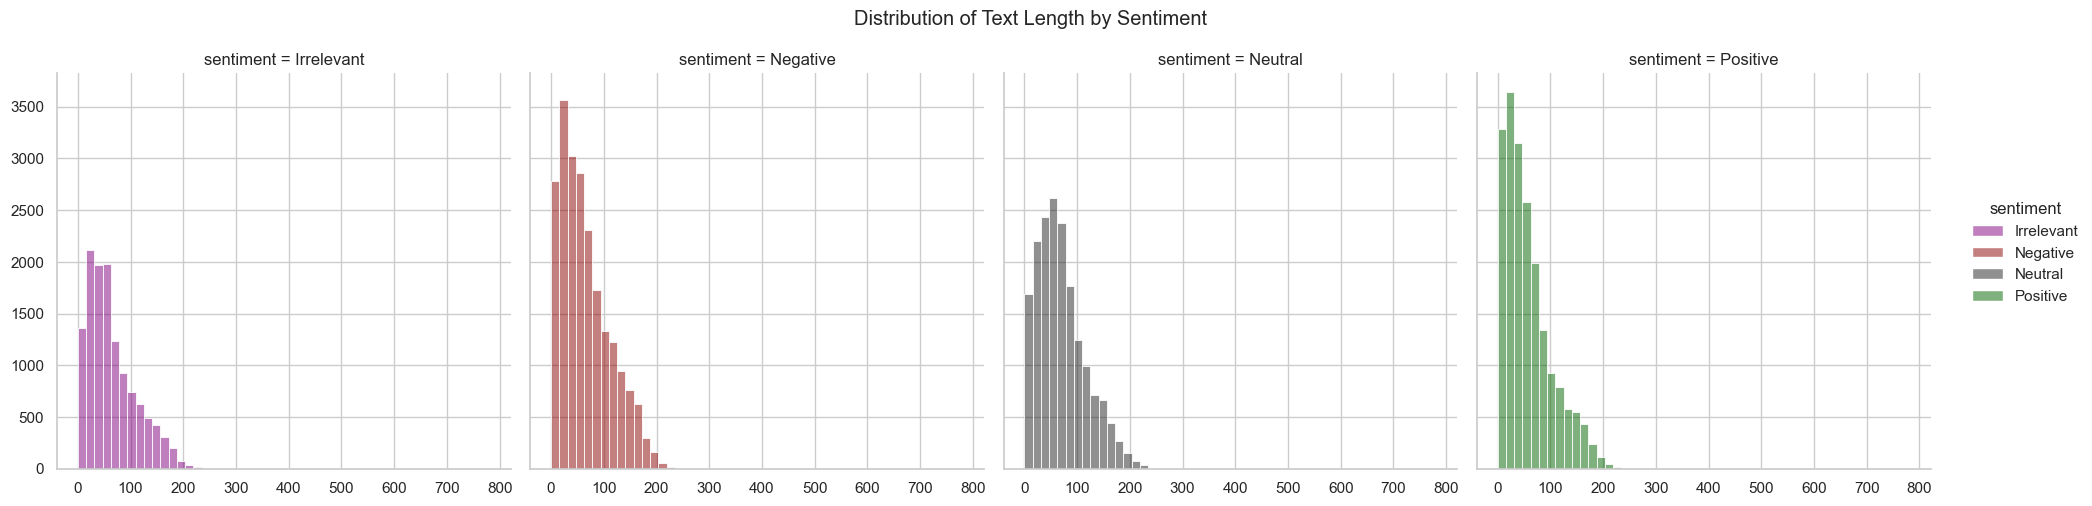

In [15]:
df['text_length'] = df['text'].str.len()

displot = sns.displot(data=df,
                      x='text_length',
                      bins=50,
                      col='sentiment',
                      hue='sentiment')

displot.fig.suptitle('Distribution of Text Length by Sentiment', y=1.05)
displot.set_axis_labels('', '')

plt.show();

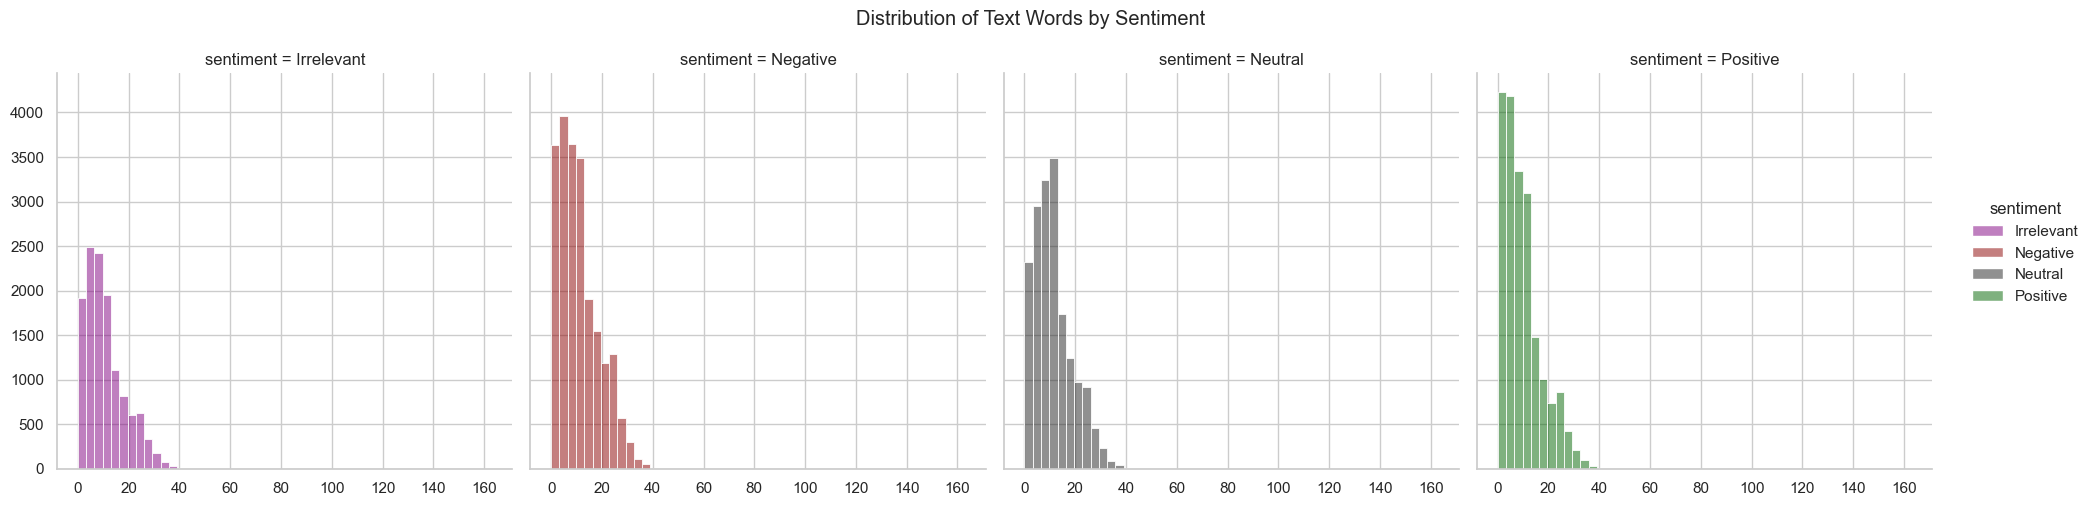

In [16]:
df['text_words'] = df['text'].str.split().str.len()

displot = sns.displot(data=df,
                      x='text_words',
                      bins=50,
                      col='sentiment',
                      hue='sentiment')

displot.fig.suptitle('Distribution of Text Words by Sentiment', y=1.05)
displot.set_axis_labels('', '')

plt.show();

In [17]:
from wordcloud import WordCloud, STOPWORDS

def create_freq_df(tokens): 
    freq_dist = nltk.FreqDist(tokens)
    df = pd.DataFrame.from_dict(freq_dist, orient='index')

    df.columns = ['Frequency']
    df.index.name = 'Token'

    return df.sort_values(by='Frequency', ascending=False).reset_index()

def create_top15_words(df, title, color, ax):
    sns.barplot(data=df.head(15), x='Token', y='Frequency', palette=color, ax=ax)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel('')

def create_wordcloud(df, title, color, ax):
    data = df.set_index('Token').to_dict()['Frequency']

    wordcloud = WordCloud(width=800,
                          height=400,
                          max_words=100,
                          max_font_size=200,
                          min_font_size=1,
                          colormap=color,
                          background_color='white',
                          random_state=42).generate_from_frequencies(data)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16)
    ax.axis('off')

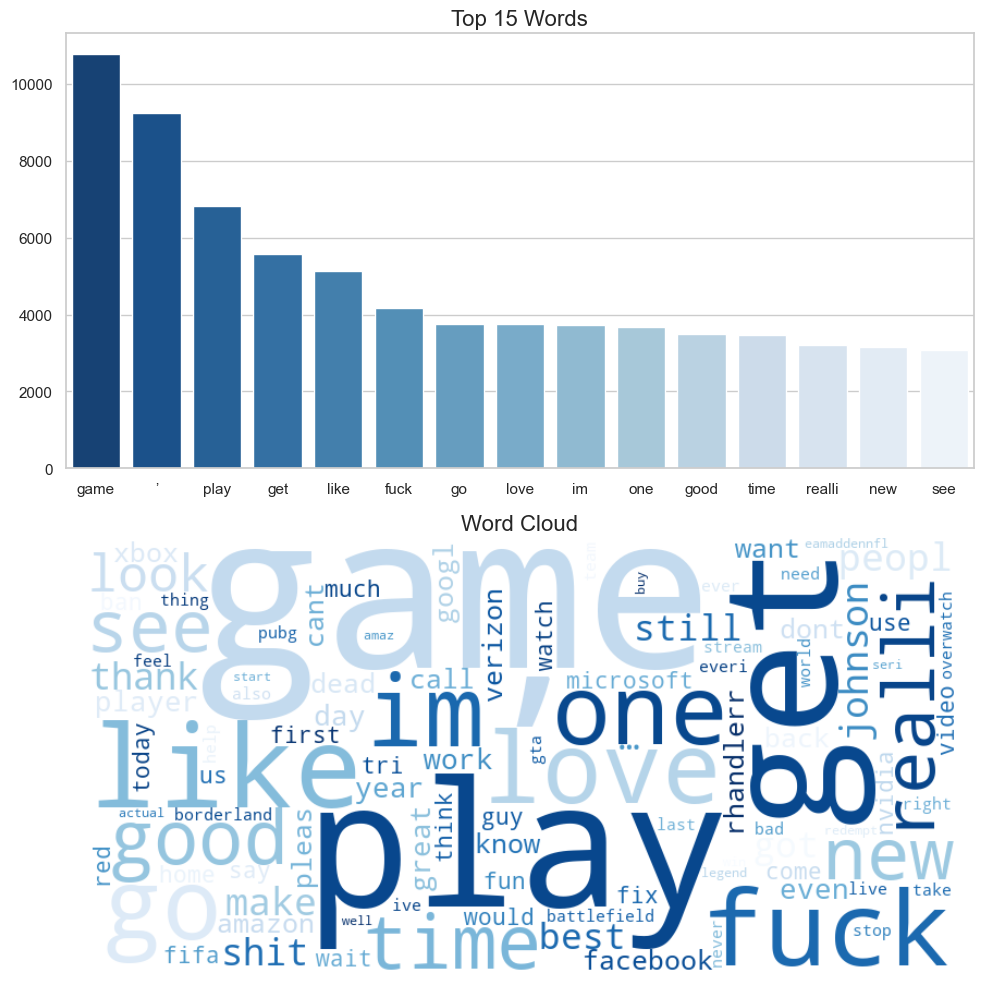

In [18]:
tokens = word_tokenize(' '.join(df['text']))
freq_df = create_freq_df(tokens)

fig, (bar_ax, cloud_ax) = plt.subplots(2, figsize=(10, 10))

create_top15_words(freq_df, 'Top 15 Words', 'Blues_r', bar_ax)
create_wordcloud(freq_df, 'Word Cloud', 'Blues_r', cloud_ax)

plt.tight_layout()
plt.show();

In [19]:
def get_tokens(label):
    concatenated_posts = ' '.join(df.loc[df['sentiment'] == label, 'text'])
    return word_tokenize(concatenated_posts)

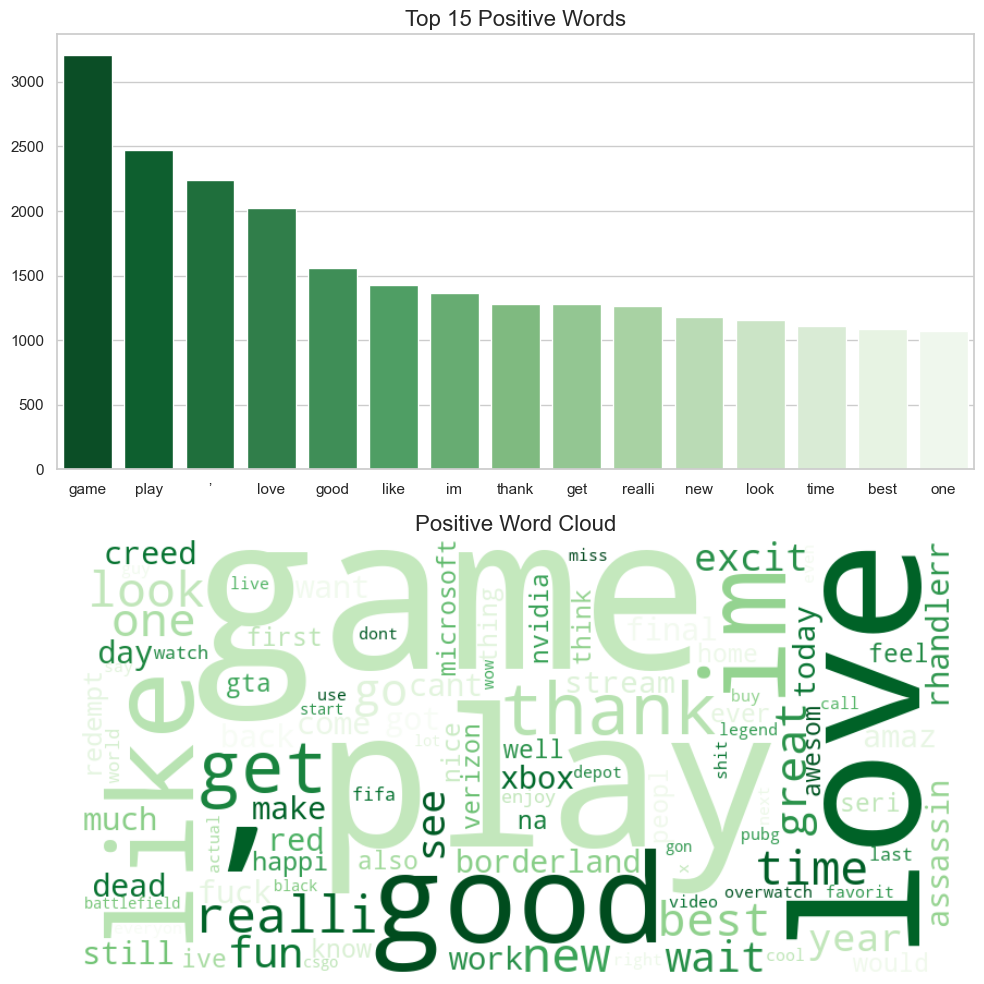

In [20]:
tokens = get_tokens('Positive')
freq_df = create_freq_df(tokens)

fig, (bar_ax, cloud_ax) = plt.subplots(2, figsize=(10, 10))

create_top15_words(freq_df, 'Top 15 Positive Words', 'Greens_r', bar_ax)
create_wordcloud(freq_df, 'Positive Word Cloud', 'Greens_r', cloud_ax)

plt.tight_layout()
plt.show();

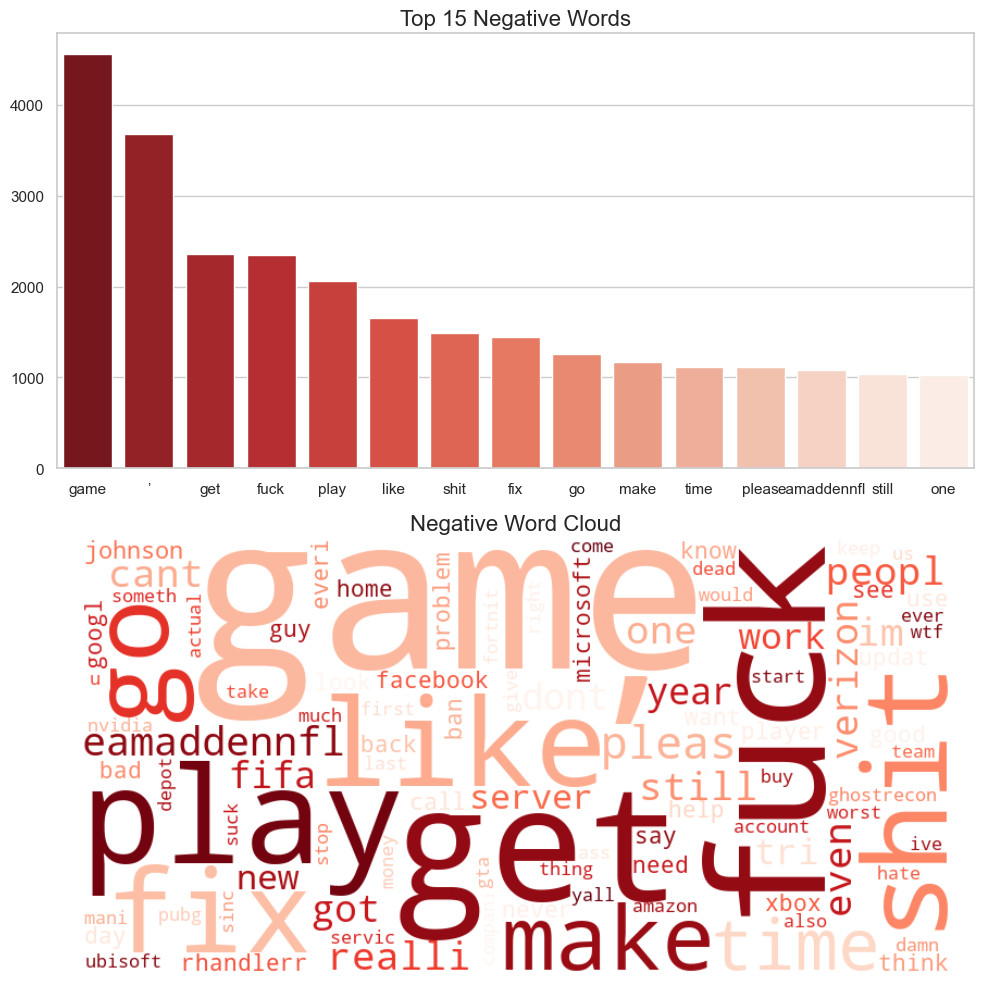

In [21]:
tokens = get_tokens('Negative')
freq_df = create_freq_df(tokens)

fig, (bar_ax, cloud_ax) = plt.subplots(2, figsize=(10, 10))

create_top15_words(freq_df, 'Top 15 Negative Words', 'Reds_r', bar_ax)
create_wordcloud(freq_df, 'Negative Word Cloud', 'Reds_r', cloud_ax)

plt.tight_layout()
plt.show();

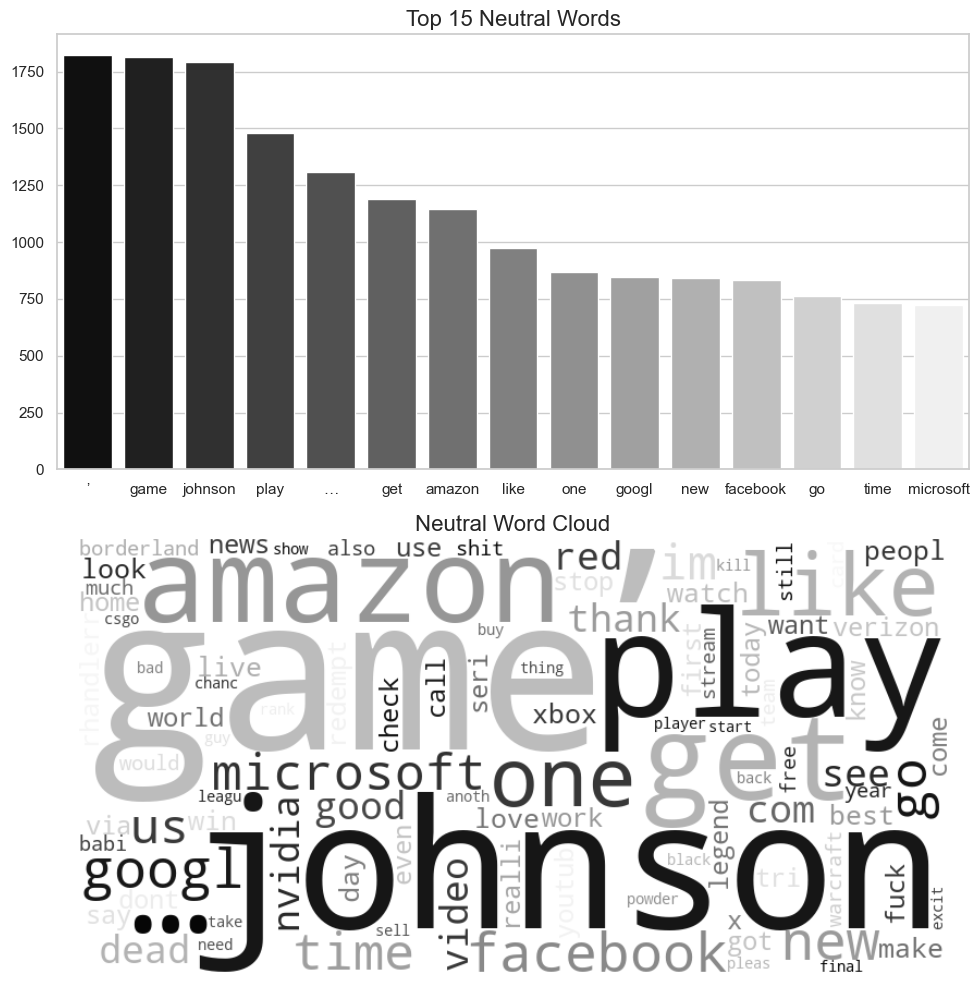

In [22]:
tokens = get_tokens('Neutral')
freq_df = create_freq_df(tokens)

fig, (bar_ax, cloud_ax) = plt.subplots(2, figsize=(10, 10))

create_top15_words(freq_df, 'Top 15 Neutral Words', 'binary_r', bar_ax)
create_wordcloud(freq_df, 'Neutral Word Cloud', 'binary_r', cloud_ax)

plt.tight_layout()
plt.show();

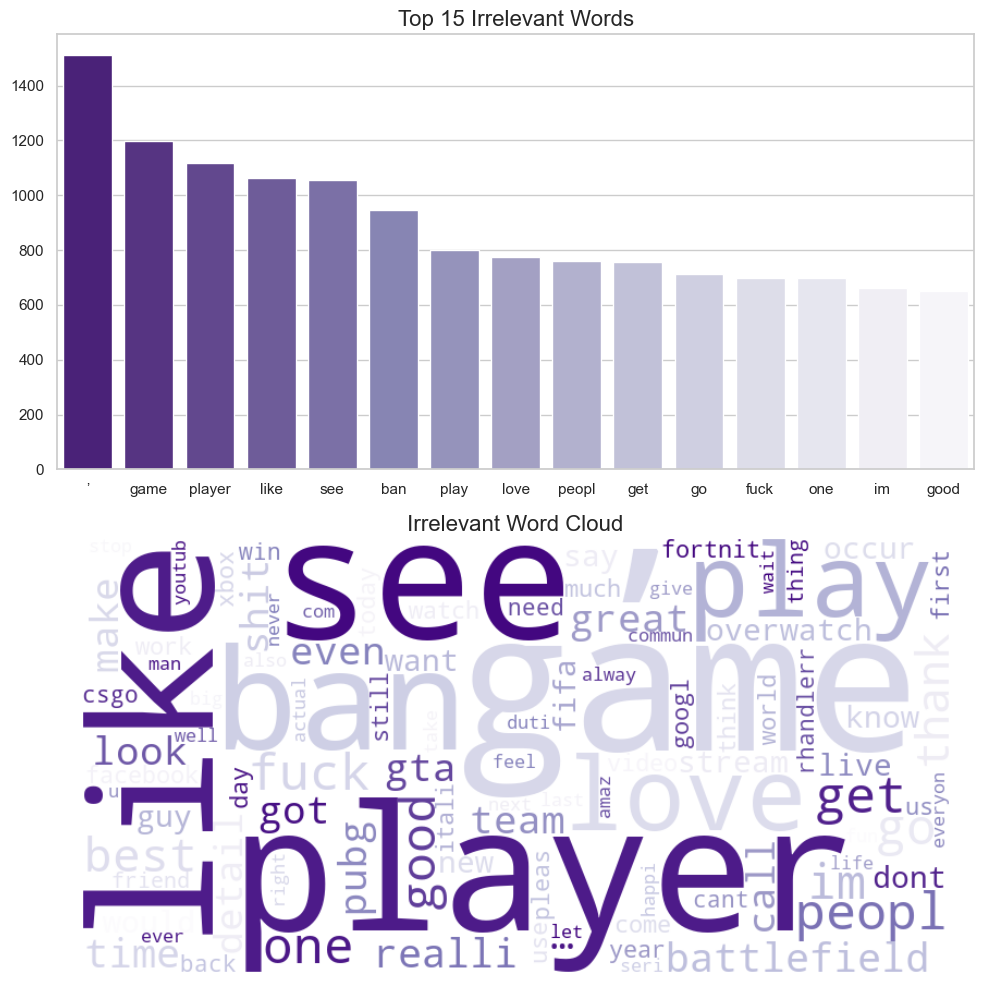

In [23]:
tokens = get_tokens('Irrelevant')
freq_df = create_freq_df(tokens)

fig, (bar_ax, cloud_ax) = plt.subplots(2, figsize=(10, 10))

create_top15_words(freq_df, 'Top 15 Irrelevant Words', 'Purples_r', bar_ax)
create_wordcloud(freq_df, 'Irrelevant Word Cloud', 'Purples_r', cloud_ax)

plt.tight_layout()
plt.show();

In [24]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_text_ngrams(ngram):
    ngram_range = (ngram, ngram)
    corpus = df['text']

    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)

    ngram_counts = bag_of_words.sum(axis=0)
    ngram_freq = [(word, ngram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    
    ngram_freq_df = pd.DataFrame(ngram_freq, columns=['N-grams', 'Frequency'])
    return ngram_freq_df.sort_values('Frequency', ascending=False).head(15)

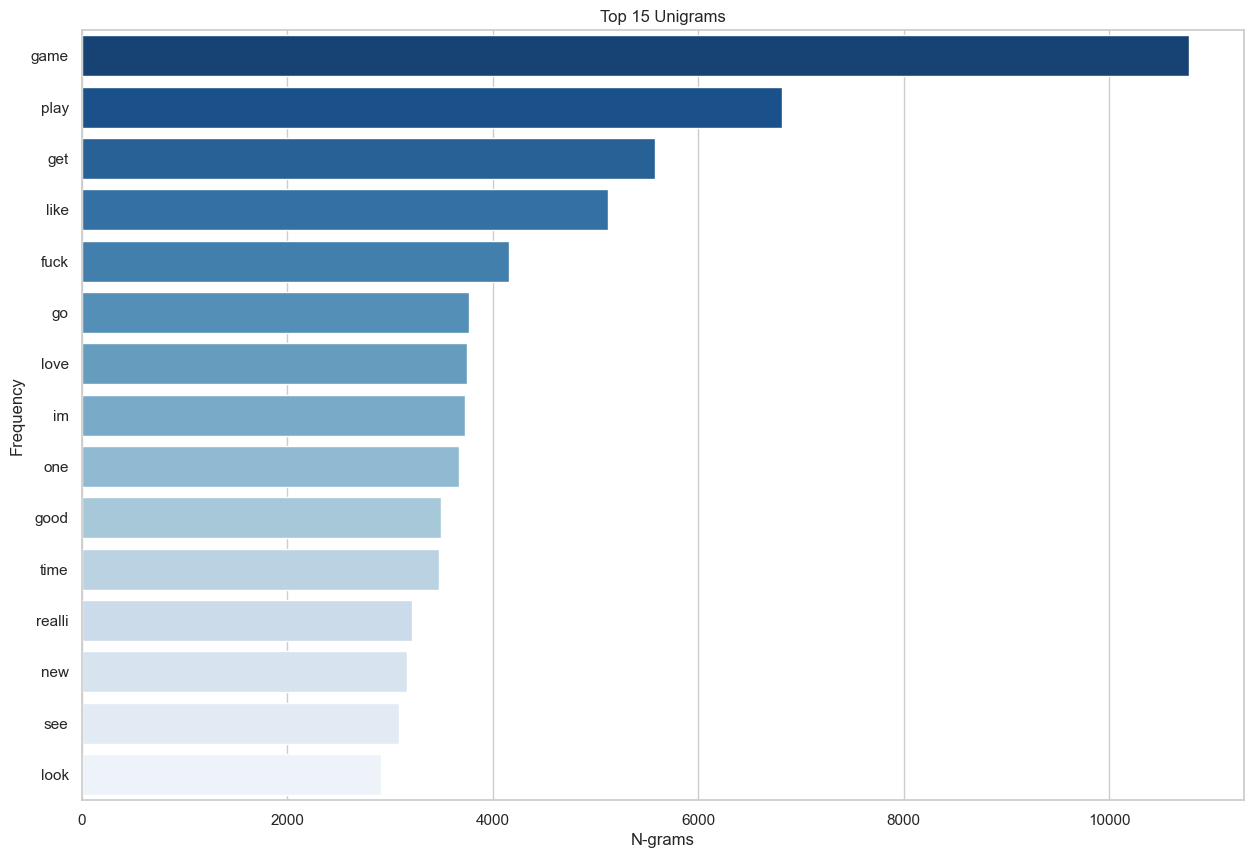

In [25]:
unigram_df = get_top_text_ngrams(ngram=1)

plt.figure(figsize=(15, 10))

sns.barplot(data=unigram_df, x='Frequency', y='N-grams', palette='Blues_r')

plt.title('Top 15 Unigrams')
plt.xlabel('N-grams')
plt.ylabel('Frequency')

plt.show()

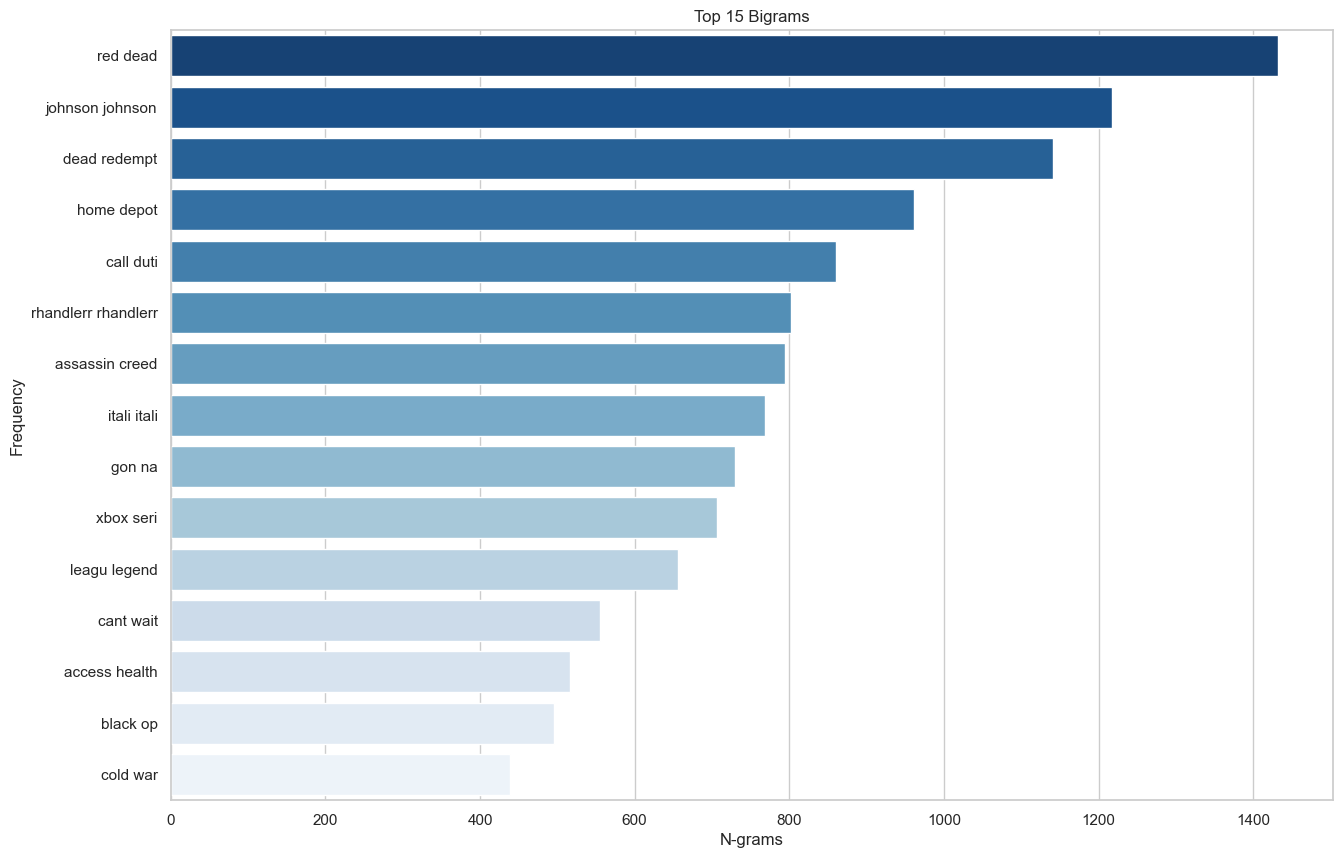

In [26]:
bigram_df = get_top_text_ngrams(ngram=2)

plt.figure(figsize=(15, 10))

sns.barplot(data=bigram_df, x='Frequency', y='N-grams', palette='Blues_r')

plt.title('Top 15 Bigrams')
plt.xlabel('N-grams')
plt.ylabel('Frequency')

plt.show();

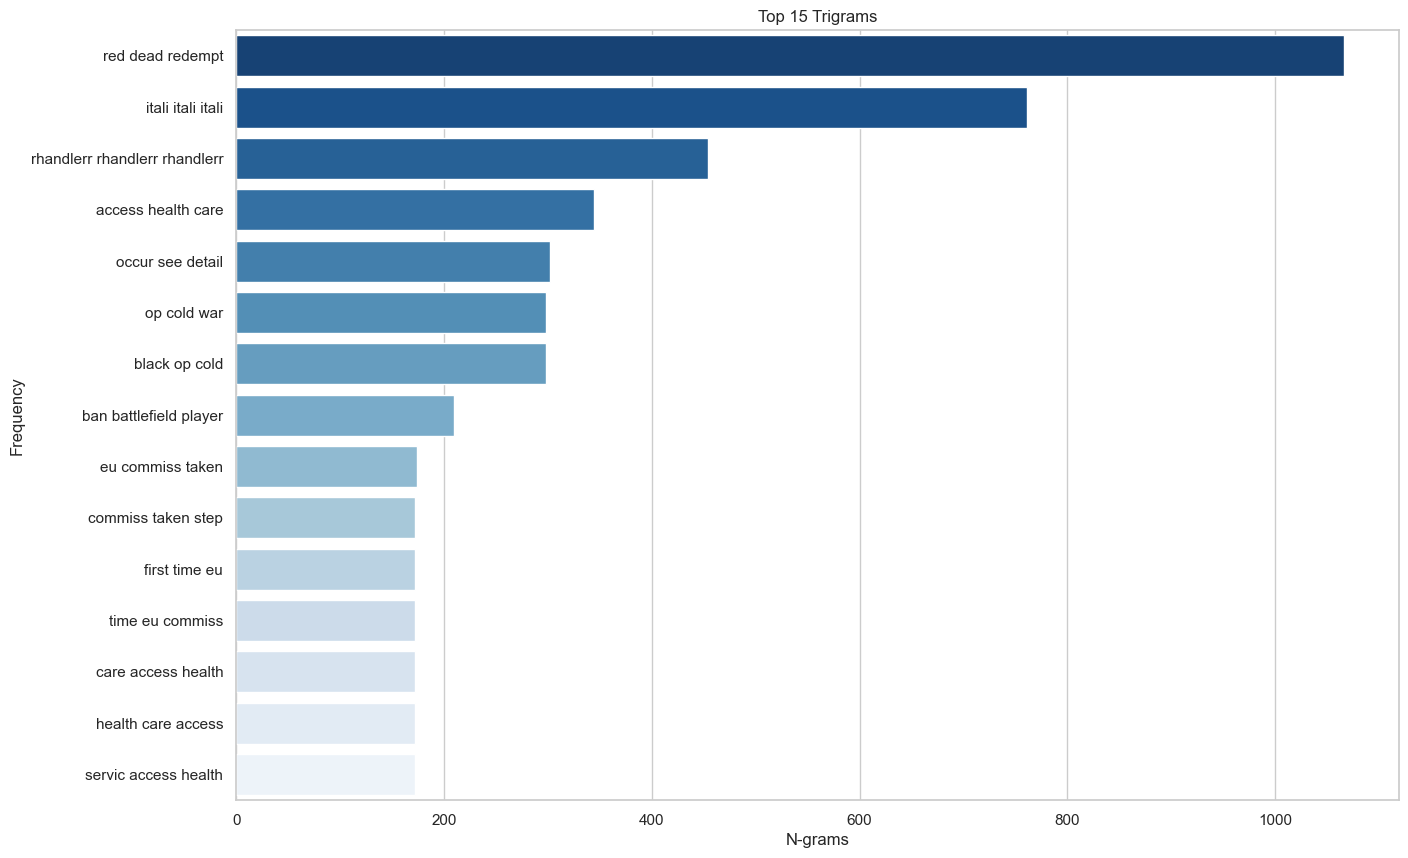

In [27]:
trigram_df = get_top_text_ngrams(ngram=3)

plt.figure(figsize=(15, 10))

sns.barplot(data=trigram_df, x='Frequency', y='N-grams', palette='Blues_r')

plt.title('Top 15 Trigrams')
plt.xlabel('N-grams')
plt.ylabel('Frequency')

plt.show();